<a href="https://colab.research.google.com/github/vikiysr/mlprojects/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder


In [ ]:
# Load train dataset
df = pd.read_csv('train.csv')

In [ ]:
test_df = pd.read_csv('test.csv')
df = pd.merge(df, test_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date',"Dept"])

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
# Load store dataset and join with above data
stores_df = pd.read_csv('stores.csv')
stores_df.head(5)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [ ]:
df.shape

(421570, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 22.9+ MB


In [ ]:
df["Weekly_Sales"].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [ ]:
print('Min Date in Data is - {}'.format(df['Date'].min()))
print('Max Date in Data is - {}'.format(df['Date'].max()))

Min Date in Data is - 2010-02-05
Max Date in Data is - 2012-10-26


  Type  Store
0    A     22
1    B     17
2    C      6


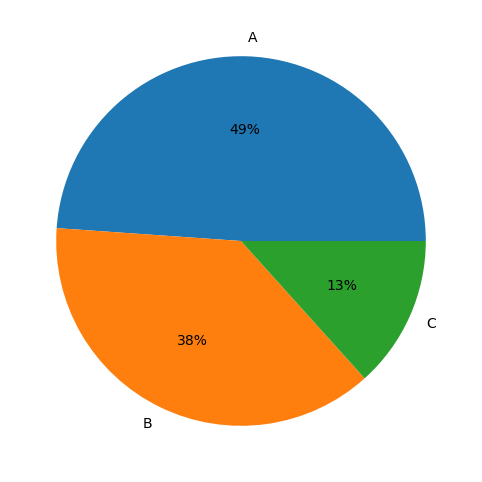

In [ ]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'], autopct = '%.0f%%')
plt.show()


<Axes: xlabel='Type', ylabel='Size'>

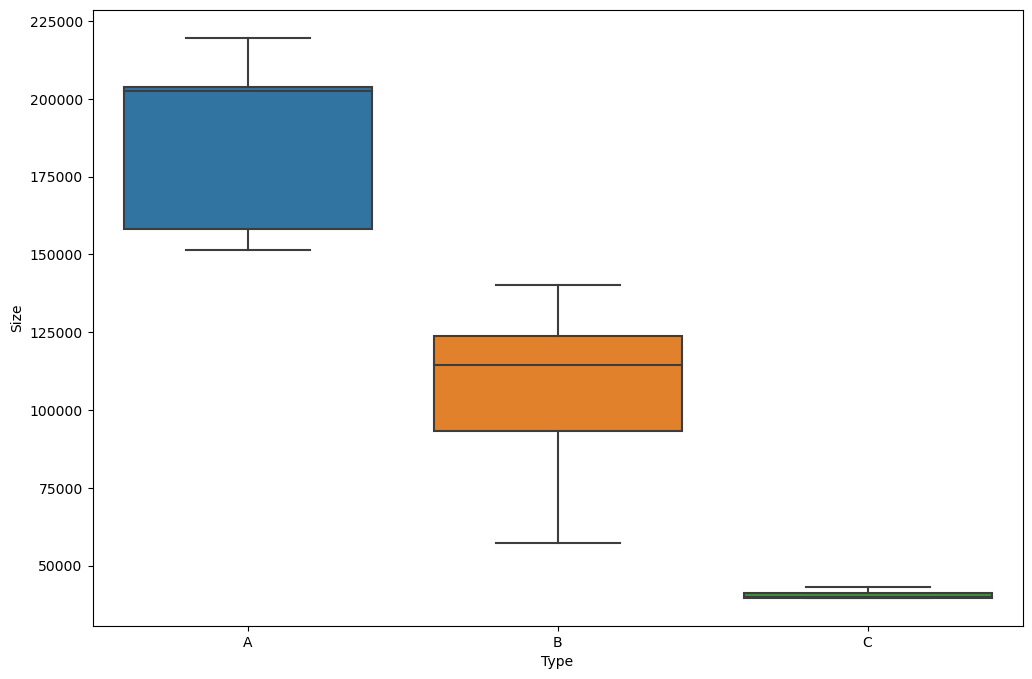

In [ ]:
# size distribution of stores for each store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)


<Axes: xlabel='Type', ylabel='Weekly_Sales'>

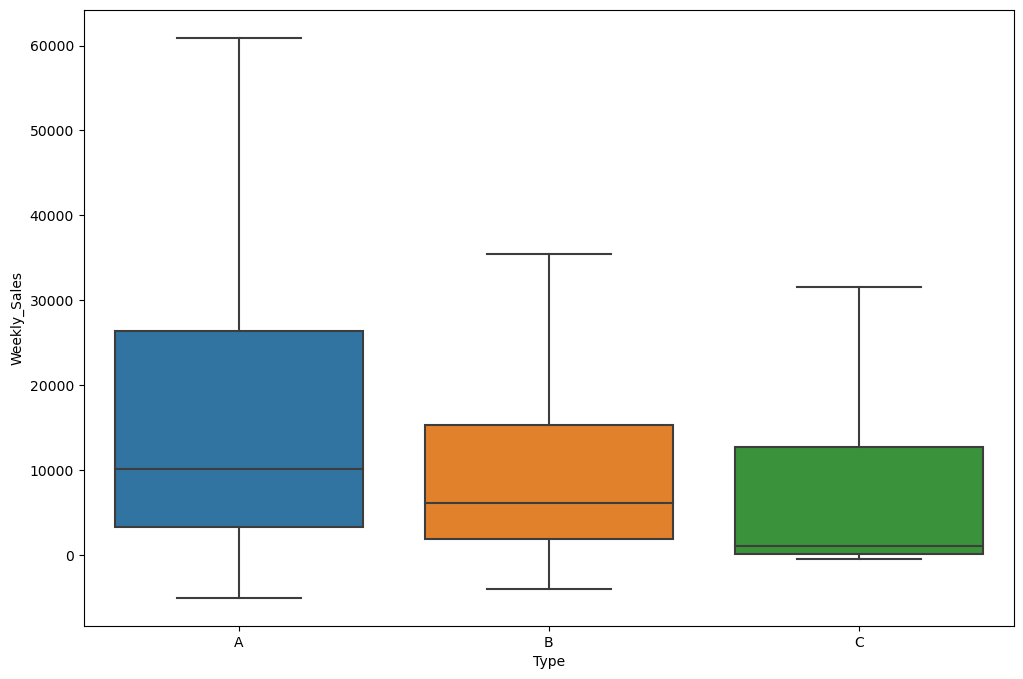

In [ ]:
# Distribution of weekly sales based on store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

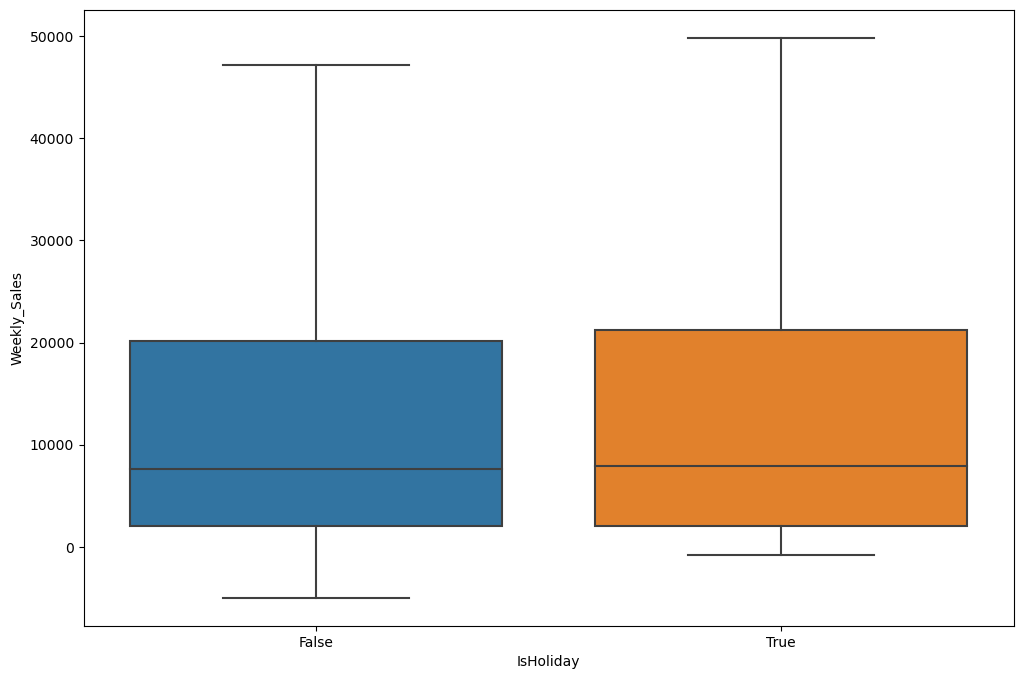

In [ ]:
# impact of holidays on weekly sales
plt.figure(figsize = (12,8))
sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)


In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [ ]:
cols=['Weekly_Sales',"Size"]
df[cols].corr()

,Weekly_Sales,Size
Weekly_Sales,1.000000,0.243828
Size,0.243828,1.000000


In [ ]:
cols_to_encode = ['Type', 'IsHoliday']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,Size,Type_B,Type_C,IsHoliday_True
0,1,1,2010-02-05,24924.50,151315,0,0,0
1,1,1,2010-02-12,46039.49,151315,0,0,1
2,1,1,2010-02-19,41595.55,151315,0,0,0
3,1,1,2010-02-26,19403.54,151315,0,0,0
4,1,1,2010-03-05,21827.90,151315,0,0,0


In [ ]:
standard_scaler = StandardScaler()
cols1 = ['Type_B','Type_C',"IsHoliday_True", 'Size']
transformed_cols1 = standard_scaler.fit_transform(df[cols1])

In [ ]:
cols1  = df.columns.tolist()
cols1 = [i for i in cols if i not in ['Date', 'Weekly_Sales']]
x_train, x_test, y_train, y_test = train_test_split(df[cols1], df['Weekly_Sales'], test_size = 0.2, random_state = 1)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors = 10, n_jobs = 4)
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_test)


In [ ]:
print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {knn_regressor.score(x_test, y_test)}')

MAE is - 14546.195425160711
RMSE is - 22542.726088266274
Accuracy Score is - 0.018267013012182143


In [ ]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor = DecisionTreeRegressor(random_state = 1234)
decision_tree_regressor.fit(x_train, y_train)
y_pred = decision_tree_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {decision_tree_regressor.score(x_test, y_test)}')


MAE is - 14260.8159468518
RMSE is - 21638.144698071213
Accuracy Score is - 0.09547503672307922


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 400, max_depth = 15, random_state = 1234, n_jobs = 5)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {rf_regressor.score(x_test, y_test)}')


MAE is - 14260.571182908798
RMSE is - 21638.0971372561
Accuracy Score is - 0.0954790130249169


In [ ]:
xgb_regressor = XGBRegressor(objective = 'reg:linear', n_estimators = 500, max_depth = 6, nthread = 4, learning_rate = 0.5, random_state = 1234)
xgb_regressor.fit(x_train, y_train)
y_pred = xgb_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {xgb_regressor.score(x_test, y_test)}')


[14:13:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
MAE is - 14260.81594579419
RMSE is - 21638.144696079147
Accuracy Score is - 0.09547503688962511


<Axes: xlabel='Weekly_Sales'>

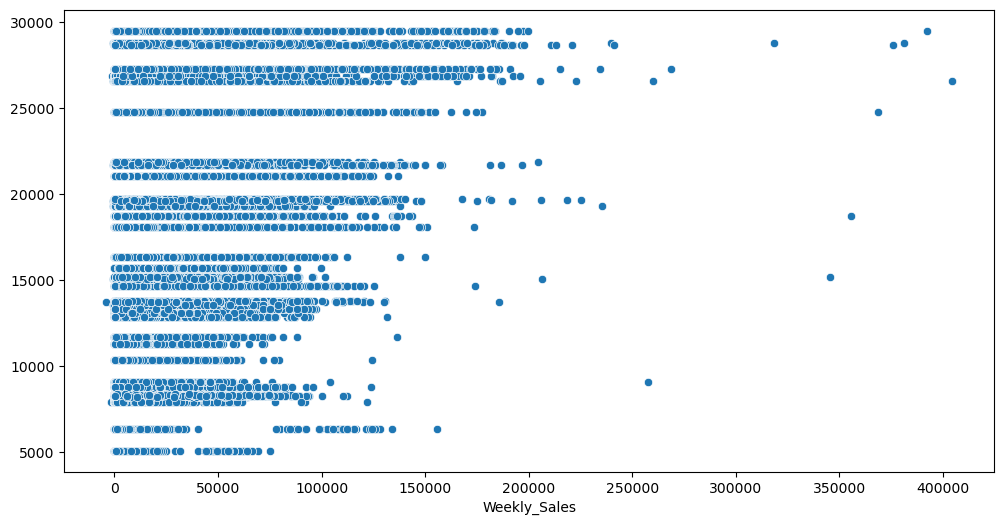

In [ ]:
# scatter plot between observed and predicted values of weekly sales from XGBoost regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)
